In [35]:
import pandas as pd
import os
import numpy as np
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/PRS')

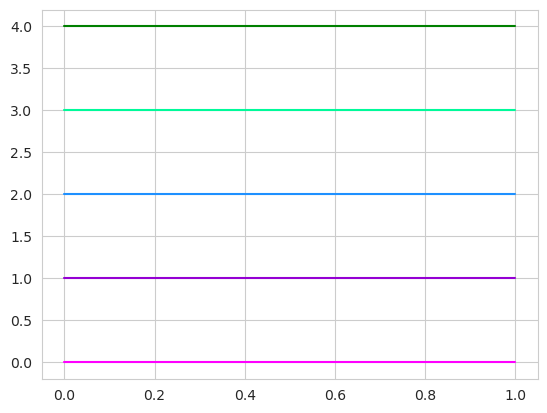

In [36]:
colors = ['fuchsia',
          'darkviolet',
          'dodgerblue',
          'mediumspringgreen',
          'g']

#colors = colors[:3]

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

new_cmap = mpl.colors.ListedColormap(colors)

colors2 = [c for c in colors]
colors2.insert(0, 'k')
new_cmap2 = mpl.colors.ListedColormap(colors2)

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [38]:
def make_quantile_plot(label_groups, quantiles, plot_ax):
    plot_ax.axhline(1, linestyle='dashed', c='silver')
    for group, col in label_groups.iteritems():
        y = col.groupby(quantiles).mean() / col.mean()
        if len(label_groups.columns) == 1:
            plot_ax.plot(y.index, y, alpha=0.5, color='k')
            plot_ax.scatter(y.index, y, label=group, c='k')
        else:
            plot_ax.plot(y.index, y, alpha=0.5)
            plot_ax.scatter(y.index, y, label=group)
    plot_ax.set_xlabel('Decile')
    plot_ax.set_ylabel('Odds Ratio')
    # plot_ax.set_ylim(0, 4)
    # plot_ax.legend()
    plot_ax.set_title(quantiles.name)

def make_rare_quantile_plot(label_groups, score_series, quantile_cuts, plot_ax):
    plot_ax.axhline(1, linestyle='dashed', c='silver')
    bins = np.quantile(score_series, quantile_cuts)
    quantiles = pd.cut(score_series, bins, labels=False, include_lowest=True) + 1
    for group, col in label_groups.iteritems():
        y = col.groupby(quantiles).mean() / col.mean()
        if len(label_groups.columns) == 1:
            plot_ax.plot(y.index, y, alpha=0.5, c='k')
            plot_ax.scatter(y.index, y, label=group, c='k')
        else:
            plot_ax.plot(y.index, y, alpha=0.5)
            plot_ax.scatter(y.index, y, label=group)
    plot_ax.set_xlabel('Quantile')
    plot_ax.set_ylabel('Odds Ratio')
    # plot_ax.set_ylim(0, 4)
    plot_ax.legend()
    plot_ax.set_xticks(quantiles.unique(), quantile_cuts[:-1])
    plot_ax.set_title(quantiles.name)

def make_roc_plot(label_groups, score_series, plot_ax, true_labels):
    plot_ax.plot([0, 1], [0, 1], linestyle='dashed', c='silver')
    for group, col in label_groups.iteritems():
        col = col.dropna()
        samples = col.index.intersection(true_labels.dropna().index).intersection(score_series.dropna().index)

        fpr, tpr, thresholds = roc_curve(col.loc[samples], score_series.loc[samples])
        auc_score = auc(fpr, tpr)
        if len(label_groups.columns) == 1:
            plot_ax.plot(fpr[1::max((len(thresholds) // 100), 1)], tpr[1::max((len(thresholds) // 100), 1)], label='AUC = ' + str(round(auc_score, 3)), color='k')
        else:
            plot_ax.plot(fpr[1::max((len(thresholds) // 100), 1)], tpr[1::max((len(thresholds) // 100), 1)], label='AUC = ' + str(round(auc_score, 3)))
        plot_ax.legend(loc='lower right')
    plot_ax.set_xlabel('False Positive Rate')
    plot_ax.set_ylabel('True Positive Rate')
    plot_ax.set_title(score_series.name)

def make_hist_or_plot(label_groups, score_series, plot_ax, x_min=-2.5, x_max=2.5):
    use_bins = np.linspace(x_min, x_max, 11)
    score_cut = pd.cut(score_series, bins=use_bins)
    plot_ax.set_xlim(x_min, x_max)

    sns.kdeplot(score_series, color='k', fill=True, ax=plot_ax, bw_adjust=3)

    ax2 = plot_ax.twinx()
    plot_ax.grid(False, axis='y')

    for group, col in label_groups.iteritems():
        prevs = col.groupby(score_cut).mean()
        prevs = prevs / col.mean()
        if len(label_groups.columns) == 1:
            ax2.plot((use_bins[:-1] + use_bins[1:]) / 2, prevs, c='k')
            ax2.scatter((use_bins[:-1] + use_bins[1:]) / 2, prevs, label=group, c='k')
        else:
            ax2.plot((use_bins[:-1] + use_bins[1:]) / 2, prevs)
            ax2.scatter((use_bins[:-1] + use_bins[1:]) / 2, prevs, label=group)

    plot_ax.set_title(score_series.name)

    # ax2.legend(ncol=1)
    ax2.set_ylabel('Odds Ratio')
    # plot_ax.set_xlabel('Logistic Probability of Being a Case')
    plot_ax.set_xlabel('Score')

In [39]:
pheno = pd.read_csv('../Feature_Extraction/cluster_phenotypes_multi_ancestry.csv', index_col='IID')
scores = pd.read_csv('all_endo_scores.csv', index_col='IID', low_memory=False)
pheno = pheno.loc[pheno.index.intersection(scores.index)]
pheno

,Dataset,ANCESTRY,CURRENT_AGE,endometriosis,cluster_vs_controls_1,cluster_vs_controls_2,cluster_vs_controls_3,cluster_vs_controls_4,cluster_vs_controls_5,Related_to_Drop,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
IID,,,,,,,,,,,,,,,,,,,,
PMBB1000437739273,PMBB,EUR,60.914442,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000073,-0.000684,-0.001725,-0.000303,-0.000011,-0.000399,0.001732,-0.002663,0.000754,0.000493
PMBB1000856639250,PMBB,EUR,78.269678,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000487,0.000200,0.000125,0.000101,-0.000420,0.000497,0.000178,0.000209,0.000466,-0.000269
PMBB1001117453706,PMBB,EUR,44.725530,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.000222,-0.000059,0.000117,0.000031,0.000016,0.000149,0.004171,0.000178,0.001654,0.001929
PMBB1001279971174,PMBB,AFR,35.942505,0.0,0.0,0.0,0.0,0.0,0.0,0,0.003143,0.001580,0.000214,0.000010,-0.000158,0.000199,-0.000404,0.001032,0.000055,0.000180
PMBB1001368577866,PMBB,EUR,41.234771,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000303,0.000022,-0.000220,-0.000113,-0.000250,-0.000360,0.000814,-0.000525,-0.001665,-0.000198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKBB6025323,UKBB,EUR,58.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000539,0.000371,0.000648,0.000731,0.001519,-0.004490,0.001568,-0.000725,0.000215,0.000140
UKBB6025341,UKBB,EUR,47.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000546,0.000121,0.000342,-0.000119,-0.000634,0.000245,-0.001639,-0.000296,0.000535,0.000094
UKBB6025362,UKBB,EUR,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.000449,0.000182,0.000270,-0.000225,-0.000053,0.000870,-0.000990,-0.000014,0.001593,0.000463


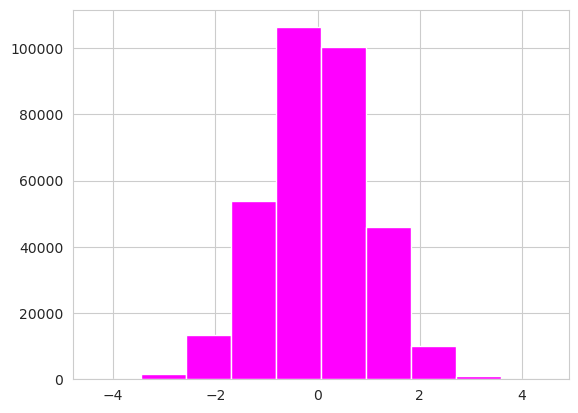

,#FID,ALLELE_CT,DENOM,NAMED_ALLELE_DOSAGE_SUM,Endo_SCORE_AVG,Endo_SCORE_SUM,Endo_Quantiles
IID,,,,,,,
PMBB1000437739273,PMBB1000437739273,76,76,42,0.483937,0.181822,7.0
PMBB1000856639250,PMBB1000856639250,74,76,39,-0.234050,0.009859,5.0
PMBB1001117453706,PMBB1001117453706,76,76,33,-2.228047,-0.467715,1.0
PMBB1001279971174,PMBB1001279971174,76,76,39,-0.238430,0.008810,5.0
PMBB1001368577866,PMBB1001368577866,74,76,36,-0.457911,-0.043757,4.0
...,...,...,...,...,...,...,...
UKBB6025323,6025323,74,76,40,0.614682,0.156333,8.0
UKBB6025341,6025341,74,76,37,-0.386942,-0.073533,4.0
UKBB6025362,6025362,76,76,40,0.182252,0.057093,6.0


In [40]:
for dataset, subDF in scores.groupby(pheno['Dataset']):
    scores.loc[subDF.index, 'Endo_SCORE_AVG'] = (subDF['Endo_SCORE_AVG'] - subDF['Endo_SCORE_AVG'].mean()) / subDF['Endo_SCORE_AVG'].std()
    scores.loc[subDF.index, 'Endo_Quantiles'] = pd.qcut(subDF['Endo_SCORE_AVG'], 10, labels=False) + 1

plt.hist(scores['Endo_SCORE_AVG'])
plt.show()

scores

In [41]:
pheno['Dataset'].value_counts()

UKBB      257699
eMERGE     53829
PMBB       21136
Name: Dataset, dtype: int64

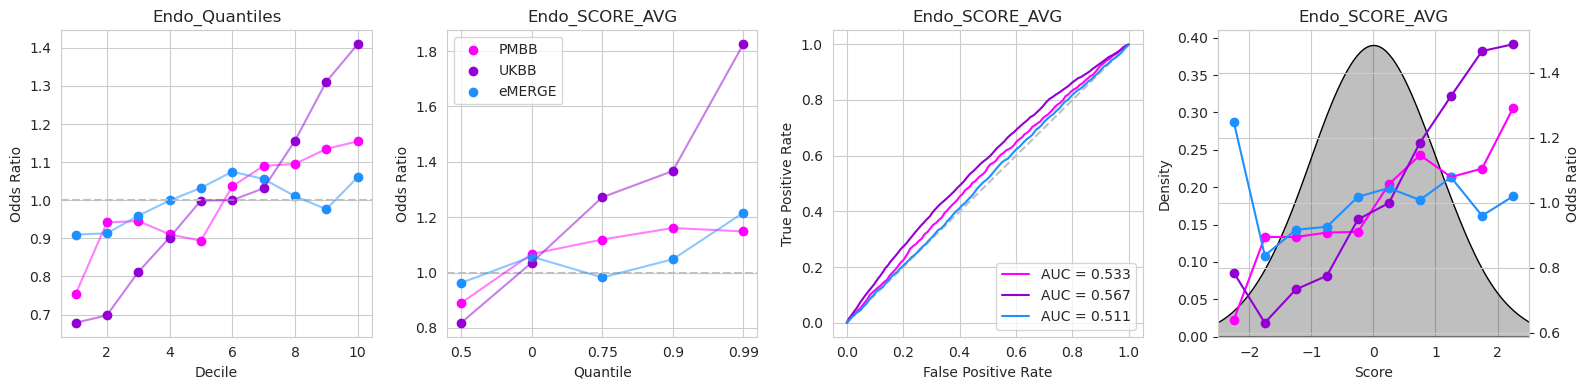

In [42]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)

enc = OneHotEncoder(sparse=False)
enc.fit(pheno[['Dataset']])
dataset_groups = pd.DataFrame(enc.transform(pheno[['Dataset']]), index=pheno.index, columns=list(enc.categories_[0]))

endo_2D = np.broadcast_to(pheno['endometriosis'], (3, len(pheno))).T.astype(int)

plot_groups = dataset_groups + endo_2D
plot_groups = plot_groups.replace({0: np.nan, 1: 0, 2: 1})

plot_groups.fillna('NA').apply(lambda x: x.value_counts(), result_type='expand')

make_quantile_plot(plot_groups, quantiles=scores['Endo_Quantiles'], plot_ax=axes[0])

make_rare_quantile_plot(plot_groups, scores['Endo_SCORE_AVG'], quantile_cuts=[0, 0.5, 0.75, 0.9, 0.99, 1], plot_ax=axes[1])

make_roc_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[2], true_labels=pheno['endometriosis'])

make_hist_or_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[3])

plt.tight_layout()
os.makedirs('Plots/', exist_ok=True)
plt.savefig('Plots/endo_scores_by_datasets_multipane.png', bbox_inches='tight')
plt.show()

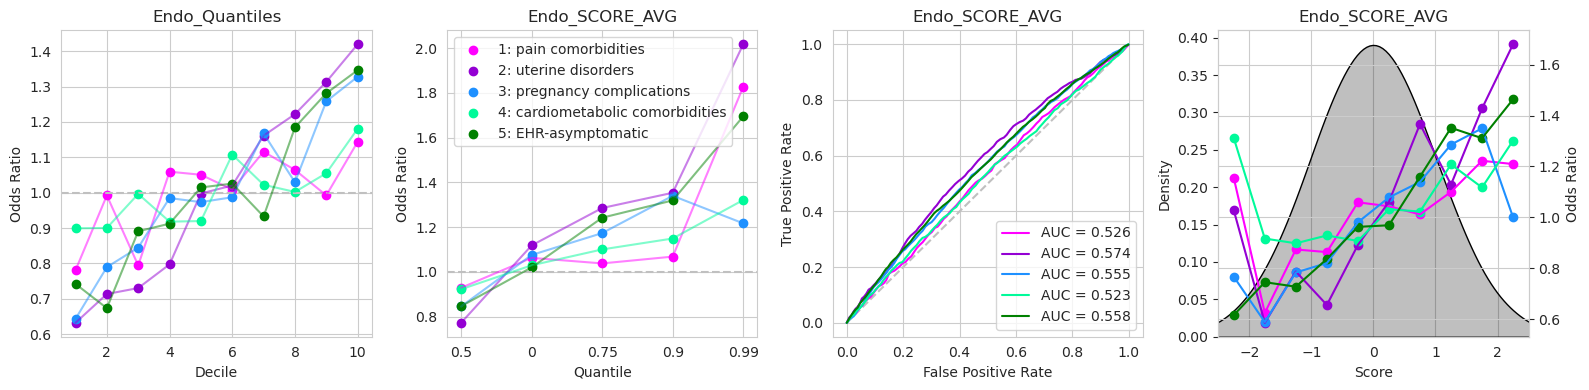

In [43]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)

pheno_map = {'cluster_vs_controls_1': '1: pain comorbidities',
             'cluster_vs_controls_2': '2: uterine disorders',
             'cluster_vs_controls_3': '3: pregnancy complications',
             'cluster_vs_controls_4': '4: cardiometabolic comorbidities',
             'cluster_vs_controls_5': '5: EHR-asymptomatic',
             'endometriosis': '0: baseline endometriosis'}

cluster_cols = [c for c in pheno if 'cluster_' in c]
plot_groups = pheno[cluster_cols].copy()
plot_groups = plot_groups.rename(columns=pheno_map)

plot_groups.fillna('NA').apply(lambda x: x.value_counts(), result_type='expand')

make_quantile_plot(plot_groups, quantiles=scores['Endo_Quantiles'], plot_ax=axes[0])

make_rare_quantile_plot(plot_groups, scores['Endo_SCORE_AVG'], quantile_cuts=[0, 0.5, 0.75, 0.9, 0.99, 1], plot_ax=axes[1])

make_roc_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[2], true_labels=pheno['endometriosis'])

make_hist_or_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[3])

plt.tight_layout()
os.makedirs('Plots/', exist_ok=True)
plt.savefig('Plots/endo_scores_by_clusters_multipane.png', bbox_inches='tight')
plt.show()

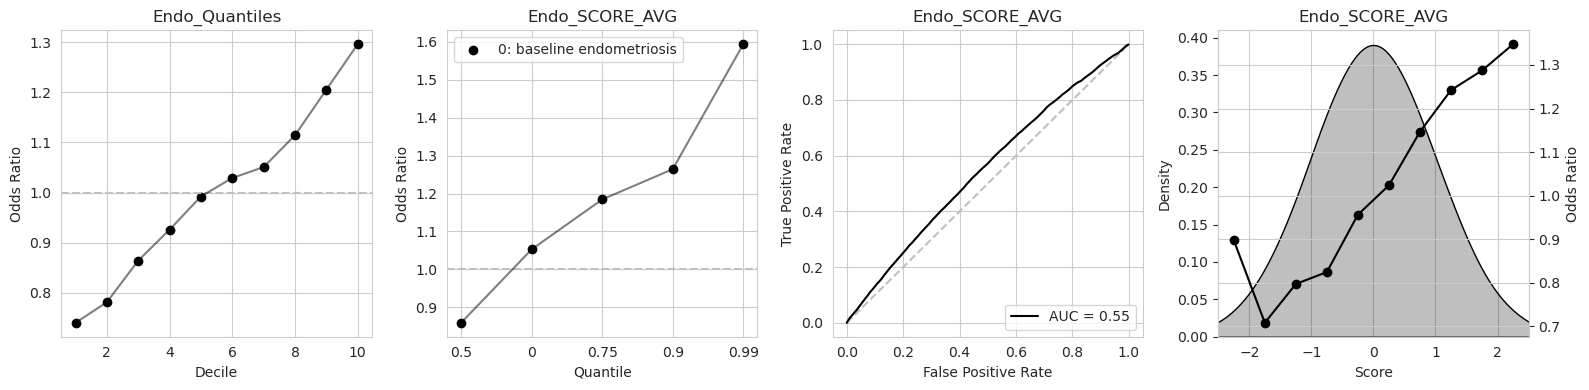

In [44]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)

pheno_map = {'cluster_vs_controls_1': '1: pain comorbidities',
             'cluster_vs_controls_2': '2: uterine disorders',
             'cluster_vs_controls_3': '3: pregnancy complications',
             'cluster_vs_controls_4': '4: cardiometabolic comorbidities',
             'cluster_vs_controls_5': '5: EHR-asymptomatic',
             'endometriosis': '0: baseline endometriosis'}

cluster_cols = [c for c in pheno if 'cluster_' in c]
plot_groups = pheno[['endometriosis']].copy()
plot_groups = plot_groups.rename(columns=pheno_map)

plot_groups.fillna('NA').apply(lambda x: x.value_counts(), result_type='expand')

make_quantile_plot(plot_groups, quantiles=scores['Endo_Quantiles'], plot_ax=axes[0])

make_rare_quantile_plot(plot_groups, scores['Endo_SCORE_AVG'], quantile_cuts=[0, 0.5, 0.75, 0.9, 0.99, 1], plot_ax=axes[1])

make_roc_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[2], true_labels=pheno['endometriosis'])

make_hist_or_plot(plot_groups, scores['Endo_SCORE_AVG'], plot_ax=axes[3])

plt.tight_layout()
os.makedirs('Plots/', exist_ok=True)
plt.savefig('Plots/endo_scores_baseline_multipane.png', bbox_inches='tight')
plt.show()

0.0    324631
5.0      2857
3.0      1500
4.0      1381
2.0      1353
1.0       942
Name: Cluster, dtype: int64


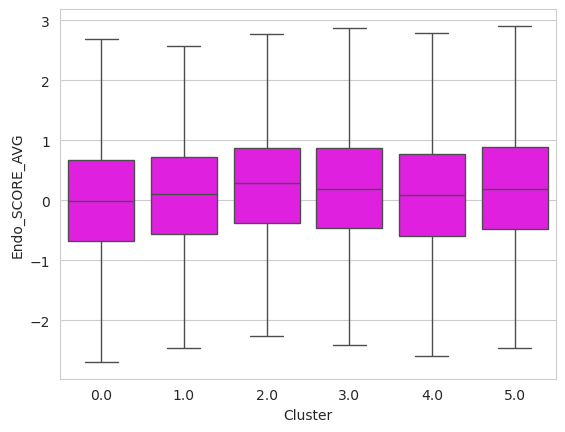

In [45]:
scores['Cluster'] = (np.broadcast_to(np.arange(1, 6), pheno[cluster_cols].shape) * pheno[cluster_cols]).sum(axis=1)
print(scores['Cluster'].value_counts())
sns.boxplot(y=scores['Endo_SCORE_AVG'], x=scores['Cluster'], showfliers=False)
plt.show()